In [4]:
# album_blur.ipynb
# Created 8-25-19 by Eric Graves
# See spotify_album_blur.md for more information

In [10]:
# Imports and environment setup
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
%matplotlib inline

# DEBUG shows input and output images, DEBUG_VERBOSE shows images and sizes at each step
DEBUG = True
DEBUG_VERBOSE = True

if not DEBUG :
    DEBUG_VERBOSE = False # Can only be enabled in DEBUG mode

# Test image name
TEST_IMAGE = 'IMG_3723_ART.PNG'# Brockhampton Saturation III album art 

(594, 592, 4)


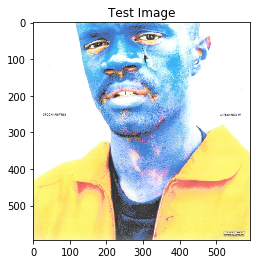

In [11]:
# Read image, set size
img = plt.imread(TEST_IMAGE, 0)
h,w = img.shape[:2]
if DEBUG_VERBOSE :
    print(img.shape)
    plt.imshow(img) 
    plt.title("Test Image")
    plt.show()

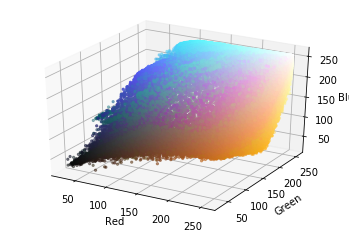

In [14]:
# Visualize image color components
# Not needed in production, but useful to debug image thresholds
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

vis_img = cv.imread(TEST_IMAGE) # Change to test different images

r, g, b = cv.split(vis_img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = vis_img.reshape((np.shape(vis_img)[0]*np.shape(vis_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()